In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
import keras
from keras.applications.mobilenet import MobileNet

from sklearn.metrics import confusion_matrix
from keras.layers.core import Dense, Activation
from keras.metrics import categorical_crossentropy
from keras.metrics import binary_crossentropy
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
from keras.preprocessing import image

In [5]:
train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    shear_range = 0.3,
    zoom_range = 0.3,
    horizontal_flip = True,
)
validation_datagen = image.ImageDataGenerator(
    rescale = 1./255
)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
train = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Lung_CancerLV/Train70',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

validation = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Lung_CancerLV/Validation10',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

test = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Lung_CancerLV/Test20',
    target_size = (224, 224),
    batch_size = 32,
    shuffle = False,
    class_mode = 'categorical'
)

Found 10543 images belonging to 3 classes.
Found 1504 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [8]:
MobileNetv2 = tf.keras.applications.MobileNetV2(
    include_top=False, 
    weights = 'imagenet', 
    input_shape=(224,224,3),
    )

9406464/9406464 [==============================] - 0s 0us/step


In [9]:
MobileNetv2.trainable = False

In [10]:
model = tf.keras.models.Sequential([
  MobileNetv2,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(units=1024, activation='relu'),
  tf.keras.layers.Dense(units=512, activation='relu'),
  tf.keras.layers.Dense(units=3, activation='softmax'), 
])

In [11]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dropout (Dropout)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 1024)              64226304  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 3)                 1539      
                                                        

In [12]:
history = model.fit(
    x = train, 
    validation_data = validation,
    epochs = 15
)

Epoch 1/15
330/330 [==============================] - 3697s 11s/step - loss: 0.8574 - accuracy: 0.8961 - val_loss: 0.1560 - val_accuracy: 0.9322
Epoch 2/15
330/330 [==============================] - 225s 681ms/step - loss: 0.1820 - accuracy: 0.9352 - val_loss: 0.1817 - val_accuracy: 0.9335
Epoch 3/15
330/330 [==============================] - 224s 680ms/step - loss: 0.1558 - accuracy: 0.9438 - val_loss: 0.1011 - val_accuracy: 0.9621
Epoch 4/15
330/330 [==============================] - 222s 673ms/step - loss: 0.1508 - accuracy: 0.9495 - val_loss: 0.0798 - val_accuracy: 0.9747
Epoch 5/15
330/330 [==============================] - 224s 680ms/step - loss: 0.1347 - accuracy: 0.9518 - val_loss: 0.0695 - val_accuracy: 0.9701
Epoch 6/15
330/330 [==============================] - 222s 672ms/step - loss: 0.1258 - accuracy: 0.9545 - val_loss: 0.0756 - val_accuracy: 0.9741
Epoch 7/15
330/330 [==============================] - 221s 669ms/step - loss: 0.1096 - accuracy: 0.9573 - val_loss: 0.0843 - 

In [13]:
# Evaluate the loss and accuracy
loss, accuracy = model.evaluate(test)

# Print the accuracy
print("Accuracy: " + str(accuracy))
# Print the loss
print("Loss: " + str(loss))

94/94 [==============================] - 1234s 13s/step - loss: 0.0297 - accuracy: 0.9893
Accuracy: 0.9893333315849304
Loss: 0.029666882008314133


In [14]:
test.class_indices

{'Lung-Benign_Tissue': 0,
 'Lung_Adenocarcinoma': 1,
 'Lung_Squamous_Cell_Carcinoma': 2}

In [15]:
import numpy as np
from sklearn import metrics

predictions = model.predict(test)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = test.classes
class_labels = ['Lung-Benign_Tissue', 'Lung_Adenocarcinoma', 'Lung_Squamous_Cell_Carcinoma']
report = metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

94/94 [==============================] - 33s 341ms/step
                              precision    recall  f1-score   support

          Lung-Benign_Tissue       1.00      1.00      1.00      1000
         Lung_Adenocarcinoma       0.99      0.98      0.98      1000
Lung_Squamous_Cell_Carcinoma       0.98      0.99      0.99      1000

                    accuracy                           0.99      3000
                   macro avg       0.99      0.99      0.99      3000
                weighted avg       0.99      0.99      0.99      3000



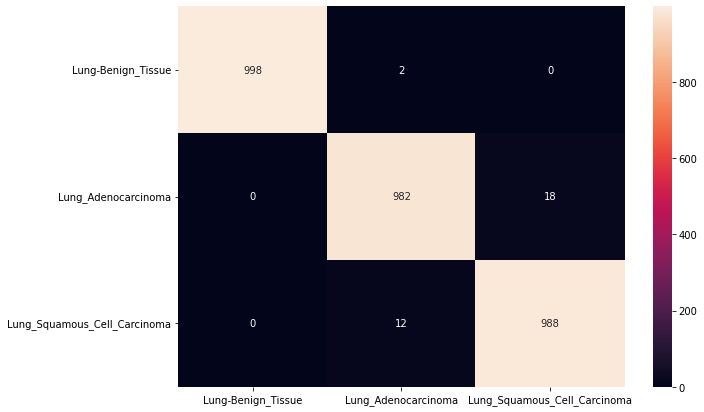

In [16]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(true_classes, predicted_classes)
df_cm = pd.DataFrame(cm, index = [i for i in ['Lung-Benign_Tissue', 'Lung_Adenocarcinoma', 'Lung_Squamous_Cell_Carcinoma']],
                  columns = [i for i in ['Lung-Benign_Tissue', 'Lung_Adenocarcinoma', 'Lung_Squamous_Cell_Carcinoma']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='d')

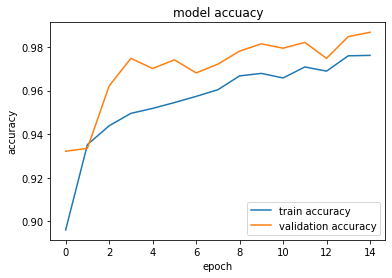

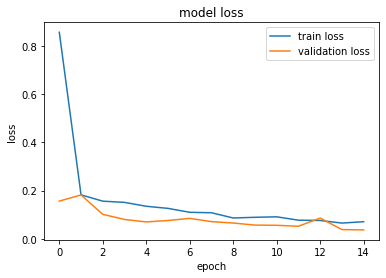

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("model accuacy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()